In [1]:
from scipy.sparse import csr_matrix
import scipy as sp
import numpy as np
trainUser = np.array([1,1,2,2,2,3]) - 1
trainItem = np.array([4,5,1,3,4,2]) - 1
n_user = 3
m_item = 5
UserItemNet = csr_matrix((np.ones(len(trainUser)), (trainUser, trainItem)),
                                      shape=(n_user, m_item))
print(UserItemNet)

  (0, 3)	1.0
  (0, 4)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (1, 3)	1.0
  (2, 1)	1.0


In [4]:
np.arange(4)

array([0, 1, 2, 3])

In [15]:
import torch
a = torch.randn((40000,1,1,64))
a.shape

torch.Size([40000, 1, 1, 64])

In [20]:
import torch.nn as nn
num_steers = 2
latent_dim = 64
rank = 10
init_var = 0.1
b = nn.Parameter(torch.randn(num_steers, latent_dim, rank) * init_var)
b.shape

torch.Size([2, 64, 10])

In [23]:
c = a.matmul(b[None])

In [24]:
c.shape

torch.Size([40000, 2, 1, 10])

In [2]:
highpo_samples = np.array([2,3])
rows = np.arange(n_user)[:,None]
rows = np.repeat(rows,len(highpo_samples),axis=1).flatten()
rows

array([0, 0, 1, 1, 2, 2])

In [3]:
cols = np.tile(highpo_samples, n_user)
cols

array([2, 3, 2, 3, 2, 3])

In [24]:
rows

array([0, 0, 1, 1, 2, 2])

In [23]:
cols

array([2, 3, 2, 3, 2, 3])

In [26]:
data = np.ones_like(cols)
data

array([1, 1, 1, 1, 1, 1])

In [28]:
user_popularity = csr_matrix((data, (rows, cols)), shape=(n_user, m_item))

In [30]:
print(user_popularity)

  (0, 2)	1
  (0, 3)	1
  (1, 2)	1
  (1, 3)	1
  (2, 2)	1
  (2, 3)	1


In [32]:
user_popularity = user_popularity.multiply(UserItemNet)
print(user_popularity)

  (0, 3)	1.0
  (1, 2)	1.0
  (1, 3)	1.0


In [7]:
highpo_samples = np.array([2,3])
user_popularity[highpo_samples] = 1

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [3]:
UserItemNet[0].nonzero()[1]

array([3, 4], dtype=int32)

In [4]:
posItems = []
posItems.append(UserItemNet[0].nonzero()[1])

In [6]:
posItems.append(UserItemNet[1].nonzero()[1])
posItems

[array([3, 4], dtype=int32), array([0, 2, 3], dtype=int32)]

In [12]:
UserItemNet[0,3].__getattribute__

<method-wrapper '__getattribute__' of numpy.float64 object at 0x7fb0e284bb90>

In [12]:
import scipy.sparse as sp
adj_mat = sp.dok_matrix((n_user + m_item, n_user + m_item), dtype=np.float32)
adj_mat = adj_mat.tolil()

In [19]:
a

<8x8 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Dictionary Of Keys format>

In [13]:
R = UserItemNet.tolil()

In [14]:
adj_mat[:n_user, n_user:] = R
adj_mat[n_user:, :n_user] = R.T


In [15]:
adj_mat = adj_mat.todok()

In [33]:
print(adj_mat)

  (6, 0)	1.0
  (7, 0)	1.0
  (3, 1)	1.0
  (5, 1)	1.0
  (6, 1)	1.0
  (4, 2)	1.0
  (1, 3)	1.0
  (2, 4)	1.0
  (1, 5)	1.0
  (0, 6)	1.0
  (1, 6)	1.0
  (0, 7)	1.0


In [16]:
rowsum = np.array(adj_mat.sum(axis=1))
rowsum

array([[2.],
       [3.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.]], dtype=float32)

In [17]:
d_inv = np.power(rowsum, -0.5).flatten()
d_inv

array([0.70710677, 0.57735026, 1.        , 1.        , 1.        ,
       1.        , 0.70710677, 1.        ], dtype=float32)

In [18]:
d_mat = sp.diags(d_inv)
print(d_mat)

  (0, 0)	0.70710677
  (1, 1)	0.57735026
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	0.70710677
  (7, 7)	1.0


In [19]:
norm_adj = d_mat.dot(adj_mat)
print(norm_adj)

  (0, 7)	0.70710677
  (0, 6)	0.70710677
  (1, 6)	0.57735026
  (1, 5)	0.57735026
  (1, 3)	0.57735026
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 2)	1.0
  (5, 1)	1.0
  (6, 1)	0.70710677
  (6, 0)	0.70710677
  (7, 0)	1.0


In [20]:
norm_adj = norm_adj.dot(d_mat)
print(norm_adj)

  (0, 6)	0.49999997
  (0, 7)	0.70710677
  (1, 3)	0.57735026
  (1, 5)	0.57735026
  (1, 6)	0.40824828
  (2, 4)	1.0
  (3, 1)	0.57735026
  (4, 2)	1.0
  (5, 1)	0.57735026
  (6, 0)	0.49999997
  (6, 1)	0.40824828
  (7, 0)	0.70710677


In [21]:
norm_adj = norm_adj.tocsr()
print(norm_adj)

  (0, 6)	0.49999997
  (0, 7)	0.70710677
  (1, 3)	0.57735026
  (1, 5)	0.57735026
  (1, 6)	0.40824828
  (2, 4)	1.0
  (3, 1)	0.57735026
  (4, 2)	1.0
  (5, 1)	0.57735026
  (6, 0)	0.49999997
  (6, 1)	0.40824828
  (7, 0)	0.70710677


In [22]:
X = norm_adj
coo = X.tocoo().astype(np.float32)

In [27]:
import torch
coo = X.tocoo().astype(np.float32)
row = torch.Tensor(coo.row).long()
col = torch.Tensor(coo.col).long()
index = torch.stack([row, col])
data = torch.FloatTensor(coo.data)

In [32]:
a = torch.sparse.FloatTensor(index, data, torch.Size(coo.shape)).coalesce()

In [38]:
keep_prob = 0.6

In [39]:
random_index = torch.rand(len(a.values())) + keep_prob
random_index

tensor([1.5051, 1.4183, 1.5672, 1.1399, 0.9426, 1.4170, 1.3702, 1.5139, 1.3634,
        0.8299, 1.0084, 1.3435])

In [41]:
random_index = random_index.int().bool()

In [43]:
index = a.indices().t()
index = index[random_index]
index

tensor([[0, 6],
        [0, 7],
        [1, 3],
        [1, 5],
        [2, 4],
        [3, 1],
        [4, 2],
        [5, 1],
        [6, 1],
        [7, 0]])

In [44]:
a.indices().t()

tensor([[0, 6],
        [0, 7],
        [1, 3],
        [1, 5],
        [1, 6],
        [2, 4],
        [3, 1],
        [4, 2],
        [5, 1],
        [6, 0],
        [6, 1],
        [7, 0]])

In [47]:
import torch
row = torch.Tensor(coo.row).long()
col = torch.Tensor(coo.col).long()
index = torch.stack([row, col])

In [ ]:
index[0]

tensor([[0, 0, 1, 1, 1, 2, 3, 4, 5, 6, 6, 7],
        [6, 7, 3, 5, 6, 4, 1, 2, 1, 0, 1, 0]])

In [4]:
import numpy as np
batch_size = 5
users = np.random.randint(0,10,5)
pos = np.random.randint(0,5,5)
neg = np.random.randint(0,20,5)

In [6]:
import torch
n_dim = 5
n_user = 5
m_item = 3
embedding_user = torch.nn.Embedding(n_user, n_dim).weight
embedding_item = torch.nn.Embedding(m_item, n_dim).weight

In [7]:
torch.mul(embedding_user[0],embedding_item[0])

tensor([ 0.4374,  0.5484,  0.4191, -1.2630, -0.0174], grad_fn=<MulBackward0>)

In [49]:
all_emb = torch.cat([embedding_user, embedding_item])
all_emb

tensor([[-0.3642, -0.4743, -1.2291,  0.3904, -0.1371],
        [ 0.5780,  2.0548, -1.7331, -1.1129,  0.8137],
        [ 0.3092,  0.5179,  1.0910, -0.4013, -1.4377],
        [-0.1943,  1.1920,  0.2614,  0.5418, -1.9513],
        [ 0.3853, -0.0947,  0.1074, -0.1851,  1.2398],
        [-0.4665, -1.1952,  0.6807, -1.0512,  0.4131],
        [ 0.4097,  0.3224,  1.3734, -0.7116, -0.5134],
        [ 1.4123, -0.9352,  0.2088, -1.4172,  1.1381]], grad_fn=<CatBackward0>)

In [50]:
all_emb = torch.sparse.mm(a, all_emb)
all_emb

tensor([[ 1.2035, -0.5001,  0.8344, -1.3579,  0.5481],
        [-0.2142,  0.1298,  1.1046, -0.5846, -1.0976],
        [ 0.3853, -0.0947,  0.1074, -0.1851,  1.2398],
        [ 0.3337,  1.1863, -1.0006, -0.6425,  0.4698],
        [ 0.3092,  0.5179,  1.0910, -0.4013, -1.4377],
        [ 0.3337,  1.1863, -1.0006, -0.6425,  0.4698],
        [ 0.0539,  0.6017, -1.3221, -0.2591,  0.2636],
        [-0.2575, -0.3354, -0.8691,  0.2761, -0.0970]],
       grad_fn=<SparseAddmmBackward0>)

In [54]:
b = []

In [55]:
b.append(all_emb)
b.append(all_emb)

In [56]:
b

[tensor([[ 1.2035, -0.5001,  0.8344, -1.3579,  0.5481],
         [-0.2142,  0.1298,  1.1046, -0.5846, -1.0976],
         [ 0.3853, -0.0947,  0.1074, -0.1851,  1.2398],
         [ 0.3337,  1.1863, -1.0006, -0.6425,  0.4698],
         [ 0.3092,  0.5179,  1.0910, -0.4013, -1.4377],
         [ 0.3337,  1.1863, -1.0006, -0.6425,  0.4698],
         [ 0.0539,  0.6017, -1.3221, -0.2591,  0.2636],
         [-0.2575, -0.3354, -0.8691,  0.2761, -0.0970]],
        grad_fn=<SparseAddmmBackward0>),
 tensor([[ 1.2035, -0.5001,  0.8344, -1.3579,  0.5481],
         [-0.2142,  0.1298,  1.1046, -0.5846, -1.0976],
         [ 0.3853, -0.0947,  0.1074, -0.1851,  1.2398],
         [ 0.3337,  1.1863, -1.0006, -0.6425,  0.4698],
         [ 0.3092,  0.5179,  1.0910, -0.4013, -1.4377],
         [ 0.3337,  1.1863, -1.0006, -0.6425,  0.4698],
         [ 0.0539,  0.6017, -1.3221, -0.2591,  0.2636],
         [-0.2575, -0.3354, -0.8691,  0.2761, -0.0970]],
        grad_fn=<SparseAddmmBackward0>)]

In [60]:
b = torch.stack(b,dim=1)

In [2]:
light_out = torch.mean(b, dim=1)

NameError: name 'torch' is not defined

In [1]:
light_out[0]

NameError: name 'light_out' is not defined

In [ ]:
light_out[0]

In [63]:
tensor1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
tensor2 = torch.tensor([[7, 8, 9], [10, 11, 12]])

# 使用 torch.stack() 函数将两个张量堆叠在一起
stacked_tensor = torch.stack([tensor1, tensor2],dim=1)
stacked_tensor

tensor([[[ 1,  2,  3],
         [ 7,  8,  9]],

        [[ 4,  5,  6],
         [10, 11, 12]]])

In [ ]:
users, items = torch.split(light_out, [self.num_users, self.num_items])

In [1]:
import torch
batch_size = 5
voc = 10
rank = torch.randn(batch_size,voc)

In [2]:
rank


tensor([[ 1.2008, -1.6609,  1.9343,  1.0009, -0.5086,  0.7318,  0.6679, -0.0940,
          0.2518, -1.5456],
        [ 0.9686,  0.2994,  1.3507, -0.1406,  0.8614, -0.0312,  0.1206,  0.5280,
         -0.6347,  0.6546],
        [-0.3691,  0.7874,  0.2441, -0.1598,  1.4536, -1.1945, -0.8731,  0.7878,
         -0.0754, -0.4170],
        [-0.7047, -2.2025,  1.7144,  0.4498,  1.1371,  0.5230, -0.6301,  1.5473,
         -1.1550, -0.7806],
        [ 0.3932, -1.6229, -1.2678, -0.1566,  1.7816,  0.8374,  0.2671,  0.0594,
         -0.8235, -0.1192]])

In [3]:
a,b = torch.topk(rank, k=5)

In [4]:
a

tensor([[ 1.9343,  1.2008,  1.0009,  0.7318,  0.6679],
        [ 1.3507,  0.9686,  0.8614,  0.6546,  0.5280],
        [ 1.4536,  0.7878,  0.7874,  0.2441, -0.0754],
        [ 1.7144,  1.5473,  1.1371,  0.5230,  0.4498],
        [ 1.7816,  0.8374,  0.3932,  0.2671,  0.0594]])

In [5]:
b

tensor([[2, 0, 3, 5, 6],
        [2, 0, 4, 9, 7],
        [4, 7, 1, 2, 8],
        [2, 7, 4, 5, 3],
        [4, 5, 0, 6, 7]])

In [8]:
import numpy as np
a = np.random.randn(3, 5)


In [14]:
a[0,:2]=1

In [15]:
a

array([[ 1.        ,  1.        ,  2.58089788,  0.36540889,  1.        ],
       [ 1.81336212,  0.14038956,  0.64086827,  0.96425241,  1.        ],
       [-1.22044359, -1.11297507,  0.11281308, -0.47448022,  1.        ]])

In [9]:
import numpy as np
k = 5
b =  1./np.log2(np.arange(2, k + 2))

In [10]:
b

array([1.        , 0.63092975, 0.5       , 0.43067656, 0.38685281])

In [11]:
a * b

array([[-1.26063632, -0.57880695,  1.29044894,  0.15737304,  0.02228321],
       [ 1.81336212,  0.08857595,  0.32043414,  0.41528091,  0.06883264],
       [-1.22044359, -0.70220909,  0.05640654, -0.20434751, -0.13735176]])

In [4]:
import numpy as np
item_popularity = np.array([4,3,5,1,2,0,6,7])
threshold = 3
positive_samples = np.where(item_popularity > threshold)
negative_samples = item_popularity[item_popularity <= threshold]

In [5]:
positive_samples

(array([0, 2, 6, 7]),)

In [1]:
import torch
anchor_emb = torch.randn(5, 10)
pos_emb = torch.randn(5, 10)
a = torch.matmul(anchor_emb, pos_emb.T)

In [5]:
import numpy as np

# 示例数据
trainItem = np.array([1, 2, 3, 4, 5,6])
posItem = [1, 3, 5]
negItem = [2, 4]

# 生成标签数组
labels = np.where(np.isin(trainItem, posItem), 1, np.where(np.isin(trainItem, negItem), -1, 0))

print(labels)


[ 1 -1  1 -1  1  0]


In [8]:
item_popularity_labels = np.array([1,-1,1,1,-1,0])
batch_pos = np.array([0,1,2,3,4,5])




In [10]:
import torch
batch_pos_stance = torch.Tensor(item_popularity_labels[batch_pos])[:,None]
batch_pos_stance


tensor([[ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 0.]])

In [12]:
batch_pos_stance = torch.cat([batch_pos_stance, torch.ones_like(batch_pos_stance[:,0])[:,None]],1)

In [13]:
batch_pos_stance

tensor([[ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 0.,  1.]])

In [5]:
import torch
all_emb = torch.randn(3, 2)
embs = [all_emb]
for i in range(3):
    embs.append(torch.randn(3, 2))

In [6]:
embs[1]

tensor([[ 0.8539, -0.3498],
        [-0.5302,  0.9893],
        [ 1.4461, -2.2588]])

In [3]:
embs = torch.stack(embs, dim=1)
embs

tensor([[[ 1.4246, -1.9283],
         [-1.3240,  0.9631],
         [ 1.4798, -0.0739],
         [ 0.0601, -0.7485]],

        [[-0.0639, -0.6365],
         [-2.1322,  0.5168],
         [ 0.0810, -0.1695],
         [-0.6680,  0.6472]],

        [[-0.8898,  0.8885],
         [-0.0159,  0.5228],
         [-0.3950,  1.0713],
         [-2.4676,  0.3383]]])

In [4]:
light_out = torch.mean(embs, dim=1)
light_out

tensor([[ 0.4101, -0.4469],
        [-0.6958,  0.0895],
        [-0.9421,  0.7052]])

In [1]:
import numpy as np
from scipy.sparse import block_diag, csr_matrix

# Function to create a random dense block
def create_dense_block(size):
    return np.random.randn(size, size)

# Define the sizes of the diagonal blocks
block_sizes = [4, 5, 3]  # Three blocks of size 4x4, 5x5, and 3x3

# Create random dense blocks for the diagonal
blocks = [create_dense_block(size) for size in block_sizes]

# Construct a sparse block diagonal matrix using the created blocks
sparse_block_diag_matrix = block_diag(blocks, format='csr') 

In [2]:
blocks

[array([[-1.62413986, -0.89590578, -0.88175956, -1.82740039],
        [-0.91618637,  0.35564996,  0.20236409,  1.05246697],
        [ 0.49474674,  0.46514747, -0.33187069,  1.00898842],
        [-0.47808916,  1.52689969, -0.33391415,  1.10436904]]),
 array([[ 1.95589045,  0.92095285, -0.22682297,  0.64158078, -0.18790895],
        [-1.28466465, -0.35275894, -0.40412328,  1.99342409, -0.83431524],
        [-0.77282828,  0.07629163, -0.74264953, -0.41236759, -0.19701942],
        [-0.01277139, -1.22261875, -1.86451777, -1.13569071, -0.57926277],
        [ 0.88727391, -0.23101998, -0.83956408,  0.11307172,  0.52991157]]),
 array([[ 0.59488904,  0.04878309, -0.16089648],
        [ 1.8196466 , -0.44909831, -0.54323203],
        [ 0.05879724,  1.13918196, -0.477156  ]])]

In [3]:
sparse_block_diag_matrix

<12x12 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

In [4]:
print(sparse_block_diag_matrix)

  (0, 0)	-1.6241398567614558
  (0, 1)	-0.8959057768624341
  (0, 2)	-0.881759562811058
  (0, 3)	-1.8274003870243016
  (1, 0)	-0.9161863700825905
  (1, 1)	0.3556499631313622
  (1, 2)	0.20236409268560726
  (1, 3)	1.0524669694672648
  (2, 0)	0.49474673919773127
  (2, 1)	0.46514747191123307
  (2, 2)	-0.3318706939812199
  (2, 3)	1.0089884222633472
  (3, 0)	-0.47808915538094665
  (3, 1)	1.5268996868120794
  (3, 2)	-0.3339141481178797
  (3, 3)	1.1043690387483687
  (4, 4)	1.9558904519236093
  (4, 5)	0.9209528510601486
  (4, 6)	-0.22682296612057865
  (4, 7)	0.6415807759011747
  (4, 8)	-0.18790895383121048
  (5, 4)	-1.28466464652621
  (5, 5)	-0.35275894184849715
  (5, 6)	-0.4041232844026405
  (5, 7)	1.9934240920382829
  (5, 8)	-0.8343152400270181
  (6, 4)	-0.7728282784238543
  (6, 5)	0.07629163100616973
  (6, 6)	-0.7426495325487102
  (6, 7)	-0.4123675906715114
  (6, 8)	-0.19701941999604977
  (7, 4)	-0.01277138619430275
  (7, 5)	-1.222618748440354
  (7, 6)	-1.864517765057539
  (7, 7)	-1.1356907134

In [2]:
import numpy as np
rating_list = np.array([[3,4,6,2],[1,7,9,3]])
rating_items = set([item for sublist1 in rating_list for item in sublist1])

In [3]:
rating_items

{1, 2, 3, 4, 6, 7, 9}

In [5]:
from collections import Counter
count = Counter(rating_items)

In [21]:
import numpy as np
from collections import Counter
import torch
rating_list = np.array([[3,4,6,2],[1,7,9,3]])
rating_list = torch.tensor(rating_list).tolist()
print(rating_list)
rating_items_array = [item for sublist1 in rating_list for item in sublist1]
rating_items_set = set(rating_items_array)
count = Counter(rating_items_array)
print(rating_items_set)
print(count)

[[3, 4, 6, 2], [1, 7, 9, 3]]
{1, 2, 3, 4, 6, 7, 9}
Counter({3: 2, 4: 1, 6: 1, 2: 1, 1: 1, 7: 1, 9: 1})


In [ ]:
[tensor(1), tensor(3), tensor(4), tensor(1)]

In [19]:
rating_count = Counter(rating_items_array)

# 将字典项转换为元组列表
tuple_list = list(rating_count.items())

# 根据键的索引排序
sorted_tuple_list = sorted(tuple_list, key=lambda x: x[0])

# 将排序后的元组列表转换回字典
sorted_dict = dict(sorted_tuple_list)

print(list(sorted_dict.keys()))


[1, 2, 3, 4, 6, 7, 9]


1
2
3
4
6
7
9


In [3]:
rating_items = rating_items_set
rating_popularity = np.array([10,12,4,1,3,2,99])
rating_count = sorted_dict.values()

In [5]:
rating_popularity

array([10, 12,  4,  1,  3,  2, 99])

In [7]:
rating_count

dict_values([1, 1, 2, 1, 1, 1, 1])

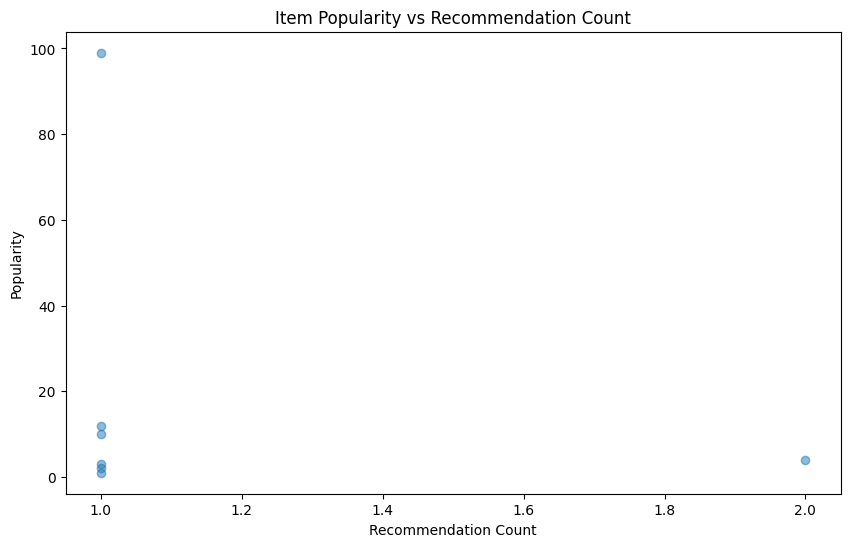

In [21]:
import matplotlib.pyplot as plt
assert len(rating_items) == len(rating_popularity) == len(rating_count), "Lists must be of the same length."

# 创建散点图
plt.figure(figsize=(10, 6))  # 设置图形的大小
plt.scatter(rating_count, rating_popularity, alpha=0.5)  
plt.title('Item Popularity vs Recommendation Count')
plt.ylabel('Popularity')
plt.xlabel('Recommendation Count')

# 显示图形
plt.show()